# Vehicle routing with higher order penalties

This notebook showcases the results of the eponymous bachelor thesis.
## Contents
* [Setup](#setup)
* [Routing Problem](#routing_problem)
* [Lane-Level Topology approach](#lane_level)
* [X-Graph approach](#x_graph)
* [Comparison](#x_graph)

## Setup <a id='setup'></a>

In [3]:
from io import StringIO
import json
import os

from typing import Optional, List

from dotenv import load_dotenv
from geojson import FeatureCollection
from mapboxgl.utils import create_color_stops
from mapboxgl.viz import LinestringViz
import matplotlib.pyplot as plt
import pandas as pd
from ortools.constraint_solver.routing_enums_pb2 import LocalSearchMetaheuristic, FirstSolutionStrategy

from src.config.map import satellite_style
from src.helpers.helpers import format_matrix
from src.osrm.interface import OSRMInterface
from src.routing_problem.connections.complete import CompleteConnection, LastConnection, FirstConnection, SelfConnection
from src.routing_problem.connections.lanelet import LaneletConnection
from src.routing_problem.connections.route import RouteConnection
from src.routing_problem.creator.creator import create_routing_problem
from src.routing_problem.lanelet import Lanelet, FirstLanelet, LastLanelet
from src.routing_problem.routing_problem import RoutingProblem

In [4]:
%load_ext autoreload
%autoreload 2

You need to create a [free Mapbox account](https://account.mapbox.com/auth/signup/) and add your access token to the .env file in the root of the repository.

In [5]:
load_dotenv()
token = os.getenv('MAPBOX_ACCESS_TOKEN')

Change the routing problem name here to load another routing problem.

In [6]:
rp_name = "stuttgart_small"
rp_path = f"data/{rp_name}.osm"

## Routing problem <a id='routing_problem'></a>

Load routing problem and show it on the interactive map

In [20]:
routing_problem: RoutingProblem = create_routing_problem(rp_path)
routing_problem.visualize()

Shorten lanelets for better visibility

In [21]:
routing_problem.shorten_lanelets()
routing_problem.visualize(zoom=14)

In [ ]:
maneuvers = dict()
for segment in routing_problem.segments:
    maneuvers.update(segment.next_maneuvers)

# Create connections. First for left and right turns, then for forward.
connections = []
for segment in routing_problem.segments:
    for previous_segment in segment.previous_segments:
        maneuver = maneuvers[(previous_segment.id, segment.id)]
        left = maneuver.modifier in [ManeuverModifier.Left, ManeuverModifier.SlightLeft,
                                     ManeuverModifier.SharpLeft, ManeuverModifier.UTurn]
        right = maneuver.modifier in [ManeuverModifier.Right, ManeuverModifier.SlightRight,
                                      ManeuverModifier.SharpRight]
        merge = maneuver.type == ManeuverType.Merge
        # Left
        if left and not merge or right and merge:
            for i, lanelet in enumerate(segment.lanelets):
                if i < len(previous_segment.lanelets):
                    connections.append(LaneletConnection(previous_segment.lanelets[i],
                                                         lanelet,
                                                         maneuver))
        # Right
        elif right and not merge or left and merge:
            for i, lanelet in enumerate(reversed(segment.lanelets)):
                if i < len(previous_segment.lanelets):
                    connections.append(LaneletConnection(previous_segment.lanelets[-(i + 1)],
                                                         lanelet,
                                                         maneuver))

# Now connect straights
for segment in routing_problem.segments:
    for previous_segment in segment.previous_segments:
        maneuver = maneuvers[(previous_segment.id, segment.id)]
        if maneuver.modifier != ManeuverModifier.Straight:
            continue

        lanelets_to = len(segment.lanelets)
        lanelets_from = len(previous_segment.lanelets)
        free_lanelets_to = list(filter(lambda x: not x.has_incoming_connection, segment.lanelets))
        free_lanelets_from = list(filter(lambda x: not x.has_outgoing_connection, previous_segment.lanelets))
        free_lanelets_to_count = len(free_lanelets_to)
        free_lanelets_from_count = len(free_lanelets_from)

        if lanelets_to == lanelets_from:
            for i in range(lanelets_to):
                connections.append(LaneletConnection(previous_segment.lanelets[i],
                                                     segment.lanelets[i],
                                                     maneuver))
        elif free_lanelets_to_count == lanelets_from:
            for i in range(free_lanelets_to_count):
                connections.append(LaneletConnection(previous_segment.lanelets[i],
                                                     free_lanelets_to[i],
                                                     maneuver))
        elif lanelets_to == free_lanelets_from_count:
            for i in range(lanelets_to):
                connections.append(LaneletConnection(free_lanelets_from[i],
                                                     segment.lanelets[i],
                                                     maneuver))
        elif lanelets_to > free_lanelets_from_count:
            for i in range(lanelets_to):
                connections.append(LaneletConnection(free_lanelets_from[min(i, free_lanelets_from_count - 1)],
                                                     segment.lanelets[i],
                                                     maneuver))
        elif lanelets_to < free_lanelets_from_count:
            for i in range(free_lanelets_from_count):
                connections.append(LaneletConnection(free_lanelets_from[i],
                                                     segment.lanelets[min(i, lanelets_to - 1)],
                                                     maneuver))

# Convert stuff to geojson
rp_json = routing_problem.to_json()
connections_json = [connection.to_json() for connection in connections]
geojson = FeatureCollection(features=rp_json + connections_json)

# Show everything on map
color_breaks = [0, 1]
color_stops = create_color_stops(color_breaks, colors=["#3ad21b", "#ff0505"])
viz = LinestringViz(data=geojson,
                    color_property="type",
                    color_stops=color_stops,
                    line_width_default='2',
                    center=(9.092, 48.731),
                    zoom=18,
                    style=satellite_style)
viz.show()

In [6]:
sources = [int(segment.id) for segment in routing_problem.segments]
destinations = sources

try:
    durations_matrix = OSRMInterface.request_table(sources, destinations, "Stuttgart/stuttgart-regbez-latest.osrm")[1]
except Exception as e:
    print(e)
else:
    matrix = format_matrix(sources, destinations, durations_matrix)

    with open("data/matrix.json", "w") as f:
        json.dump(matrix, f)
    print(f"Dumped {len(matrix)} x {len(matrix)} durations matrix")

Dumped 33 x 33 durations matrix


In [7]:
with open("data/matrix.json") as f:
    matrix = json.load(f)

In [8]:
lanelet_connections = {(connection.lanelet_from, connection.lanelet_to) for connection in connections}
optimiser = LaneletsOptimiser(lanelets=[FirstLanelet()] + routing_problem.lanelets + [LastLanelet()],
                              matrix=matrix,
                              local_search_metaheuristic=LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                              first_solution_strategy=FirstSolutionStrategy.AUTOMATIC,
                              max_optimisation_duration=2,
                              connections=lanelet_connections)
optimal_order, optimization_history = optimiser.optimise()
print(f"Optimisation history: {optimization_history}")

Optimisation history: {'0.1': 5943, '0.6': 4069, '1.1': 3997, '1.6': 3691}


In [9]:
route_connections = []

previous_connection: Optional[Lanelet] = None
for lanelet in optimal_order[1:-1]:
    if previous_connection is not None:
        cost = previous_connection.get_cost_to(lanelet,
                                            matrix,
                                            lanelet_connections)
        # if cost < 20:
        route_connections.append(RouteConnection(previous_connection,
                                                 lanelet,
                                                 cost,
                                                 1))
    previous_connection = lanelet

# Convert stuff to geojson
rp_json = routing_problem.to_json()
connections_json = [connection.to_json() for connection in route_connections]
geojson = FeatureCollection(features=rp_json + connections_json)

# Show everything on map
color_breaks = [0, 1]
color_stops = create_color_stops(color_breaks, colors=["#3ad21b", "#ff0505"])
viz = LinestringViz(data=geojson,
                    color_property="type",
                    color_stops=color_stops,
                    line_width_default='2',
                    center=(9.092, 48.731),
                    zoom=18,
                    style=satellite_style)
viz.show()

In [10]:
complete_connections: List[CompleteConnection] = [FirstConnection()]
disjunctions: List[List[int]] = []

for lanelet_to in routing_problem.lanelets:
    disjunctions.append([])
    segment_to = lanelet_to.segment

    for lanelet_from in routing_problem.lanelets:
        segment_from = lanelet_from.segment

        if (segment_from.id, segment_to.id) in maneuvers:
            maneuver = maneuvers[(segment_from.id, segment_to.id)]

            complete_connections.append(CompleteConnection(lanelet_from=lanelet_from,
                                                           lanelet_to=lanelet_to,
                                                           maneuver=maneuver))
            disjunctions[-1].append(len(complete_connections) - 1)

    if len(disjunctions[-1]) == 0:
        disjunctions = disjunctions[:-1]
        complete_connections.append(SelfConnection(lanelet_to))

complete_connections.append(LastConnection())
print(f"Created {len(complete_connections)} complete connections")

Created 155 complete connections


In [11]:
nodes_count = 0
for lanelet in routing_problem.lanelets:
    for node in lanelet.segment.nodes:
        nodes_count += 1

print(f"Segments: {len(routing_problem.segments)}")
print(f"Node based: {nodes_count}")
print(f"Edge based: {len(routing_problem.lanelets)}")
print(f"X-Graph: {len(complete_connections)}")
print(f"Disjunctions: {len(disjunctions)}")

Segments: 33
Node based: 549
Edge based: 60
X-Graph: 155
Disjunctions: 52


In [12]:
branches = 0

for lanelet in routing_problem.lanelets:
    for next_segment in lanelet.segment.next_segments:
        branches += len(next_segment.lanelets)

average_branching_factor = branches / len(routing_problem.lanelets)
print(f"Average branching factor: {round(average_branching_factor, 2)}")

Average branching factor: 2.42


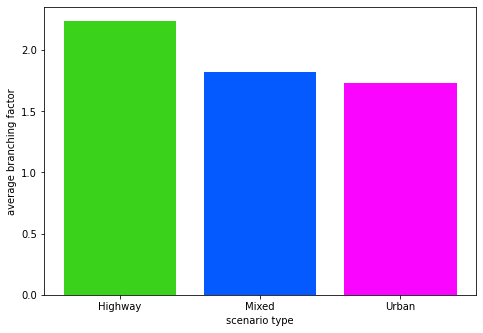

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
scenarios = ["Highway", "Mixed", "Urban"]
ys = [2.24, 1.82, 1.73]
ax.bar(scenarios, ys, color=["#3ad21b", "#055AFF", "#FA05FF"])
ax.set_ylabel('average branching factor')
ax.set_xlabel('scenario type')
plt.savefig("/Users/nitrotube/Desktop/abf.png", bbox_inches='tight', dpi=400)
plt.show()

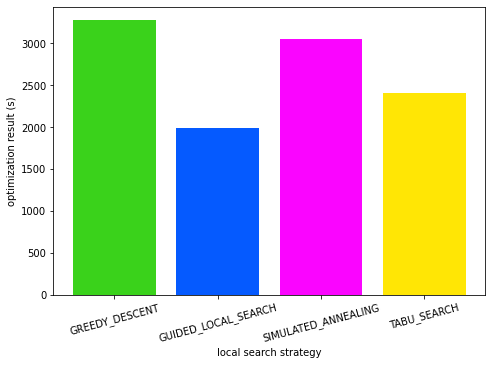

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
heuristics = ["GREEDY_DESCENT", "GUIDED_LOCAL_SEARCH", "SIMULATED_ANNEALING", "TABU_SEARCH"]
ys = [3273, 1990, 3056, 2403]
ax.bar(heuristics, ys, color=["#3ad21b", "#055AFF", "#FA05FF", "#FFE605"])
plt.xticks(rotation=15)
ax.set_ylabel('optimization result (s)')
ax.set_xlabel('local search strategy')
plt.savefig("/Users/nitrotube/Desktop/lss.png", bbox_inches='tight', dpi=400)
plt.show()

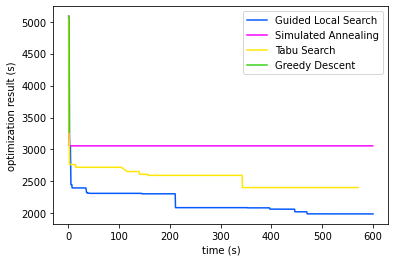

In [15]:
with open("data/lss_optimization_results.json") as f:
    optimization_results = json.load(f)

gls_x = [float(x) for x in optimization_results['GUIDED_LOCAL_SEARCH'].keys()]
gls = list(optimization_results['GUIDED_LOCAL_SEARCH'].values())

grd_x = [float(x) for x in optimization_results['GREEDY_DESCENT'].keys()]
grd = list(optimization_results['GREEDY_DESCENT'].values())

sma_x = [float(x) for x in optimization_results['SIMULATED_ANNEALING'].keys()]
sma = list(optimization_results['SIMULATED_ANNEALING'].values())

tbs_x = [float(x) for x in optimization_results['TABU_SEARCH'].keys()]
tbs = list(optimization_results['TABU_SEARCH'].values())

fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('optimization result (s)')
ax.set_xlabel('time (s)')

ax.plot(gls_x, gls, label='Guided Local Search', color="#055AFF")
ax.plot(sma_x, sma, label='Simulated Annealing', color="#FA05FF")
ax.plot(tbs_x, tbs, label='Tabu Search', color="#FFE605")
ax.plot(grd_x, grd, label='Greedy Descent', color="#3ad21b")

plt.legend()
plt.savefig("/Users/nitrotube/Desktop/lss_comparison.png", bbox_inches='tight', dpi=400)
plt.show()


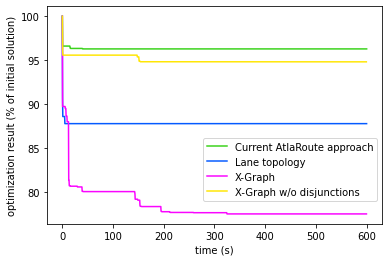

In [67]:
with open("data/approaches.json") as f:
    optimization_results = json.load(f)

current_x = [float(x) for x in optimization_results['current']['history'].keys()]
current = list(optimization_results['current']['history'].values())
max_current = max(current)
current = [(y / max_current) * 100 for y in current]

lane_topology_x = [float(x) for x in optimization_results['lane_topology']['history'].keys()]
lane_topology = list(optimization_results['lane_topology']['history'].values())
max_lane_topology = max(lane_topology)
lane_topology = [(y / max_lane_topology) * 100 for y in lane_topology]

x_graph_x = [float(x) for x in optimization_results['x_graph']['history'].keys()]
x_graph = list(optimization_results['x_graph']['history'].values())
max_x_graph = max(x_graph)
x_graph = [(y / max_x_graph) * 100 for y in x_graph]

x_graph_x_nd = [float(x) for x in optimization_results['x_graph_no_disjunctions']['history'].keys()]
x_graph_nd = list(optimization_results['x_graph_no_disjunctions']['history'].values())
max_x_graph = max(x_graph_nd)
x_graph_nd = [(y / max_x_graph) * 100 for y in x_graph_nd]

fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('optimization result (% of initial solution)')
ax.set_xlabel('time (s)')

ax.plot(current_x, current, label='Current AtlaRoute approach', color="#3ad21b")
ax.plot(lane_topology_x, lane_topology, label='Lane topology', color="#055AFF")
ax.plot(x_graph_x, x_graph, label='X-Graph', color="#FA05FF")
ax.plot(x_graph_x_nd, x_graph_nd, label='X-Graph w/o disjunctions', color="#FFE605")

ax.legend(loc="center left", bbox_to_anchor=(0.45,0.25))
plt.savefig("/Users/nitrotube/Desktop/approaches_comparison.png", bbox_inches='tight', dpi=400)
plt.show()

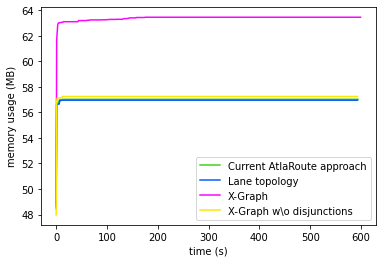

In [31]:
with open("data/approaches.json") as f:
    optimization_results = json.load(f)

current = optimization_results['current']['memory_usage']

lane_topology = optimization_results['lane_topology']['memory_usage']

x_graph = optimization_results['x_graph']['memory_usage'][:600]

x_graph_nd = optimization_results['x_graph_no_disjunctions']['memory_usage'][:600]

fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('memory usage (MB)')
ax.set_xlabel('time (s)')

ax.plot([i for i in range(len(current))], current, label='Current AtlaRoute approach', color="#3ad21b")
ax.plot([i for i in range(len(lane_topology))], lane_topology, label='Lane topology', color="#055AFF")
ax.plot([i for i in range(len(x_graph))], x_graph, label='X-Graph', color="#FA05FF")
ax.plot([i for i in range(len(x_graph_nd))], x_graph_nd, label='X-Graph w\o disjunctions', color="#FFE605")

plt.legend()
plt.savefig("/Users/nitrotube/Desktop/memory_usage.png", bbox_inches='tight', dpi=400)
plt.show()

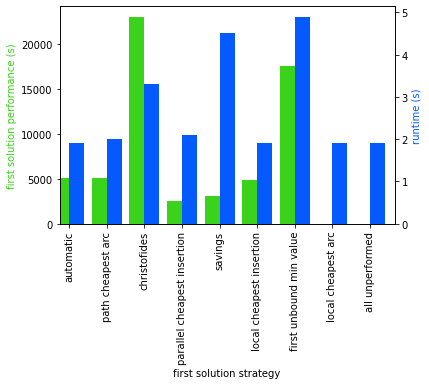

In [18]:
s = StringIO(
"""first solution strategy,performance,duration
automatic,5086,1.9
path cheapest arc,5086,2.0
christofides,23020,3.3
parallel cheapest insertion,2575,2.1
savings,3084,4.5
local cheapest insertion,4818,1.9
first unbound min value,17509,4.9
local cheapest arc,0,1.9
all unperformed,0,1.9
""")

df = pd.read_csv(s, index_col=0, delimiter=',', skipinitialspace=True)

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df.performance.plot(kind='bar', color='#3ad21b', ax=ax, width=width, position=1)
df.duration.plot(kind='bar', color='#055AFF', ax=ax2, width=width, position=0)

ax.set_ylabel('first solution performance (s)')
ax.yaxis.label.set_color('#3ad21b')
ax2.set_ylabel('runtime (s)')
ax2.yaxis.label.set_color('#055AFF')

plt.savefig("/Users/nitrotube/Desktop/fss.png", bbox_inches='tight', dpi=400)
plt.show()

In [19]:
from optimizations import optimize_lane_topology, optimize_x_graph, optimize_normal
order_x_graph = optimize_x_graph(400,
                                 straight_non_straight_maneuver_penalty=120,
                                 non_straight_straight_maneuver_penalty=0)
order_lane = optimize_lane_topology(30)
order_normal = optimize_normal(30)

Exception: Optimiser error. Route objective 0. 

In [56]:
cut_x_graph_order = order_x_graph[1:-1]
lanelets_order = []

for maneuver in cut_x_graph_order:
    lanelets_order.append(maneuver.lanelet_from)
    lanelets_order.append(maneuver.lanelet_to)

shortened_x_graph_order = []
for lanelet in lanelets_order:
    if len(shortened_x_graph_order) > 0 and shortened_x_graph_order[-1].segment.id == lanelet.segment.id:
        continue
    shortened_x_graph_order.append(lanelet)

In [57]:
segments = [lanelet.segment for lanelet in order_normal[1:-1]]
route = OSRMInterface.request_route(segments, "Stuttgart/stuttgart-regbez-latest.osrm")
print(f"Duration: {route['original_route']['routes'][0]['duration']} s")
print(f"Distance: {route['original_route']['routes'][0]['distance']} m")


Duration: 1813.6 s
Distance: 27065.3 m


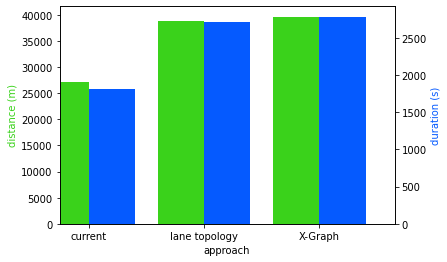

In [68]:
s = StringIO(
"""
approach,distance,duration
current,27065.3,1813.6
lane topology,38827.4,2713.5
X-Graph,39663.8,2783.0
""")

df = pd.read_csv(s, index_col=0, delimiter=',', skipinitialspace=True)

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df.distance.plot(kind='bar', color='#3ad21b', ax=ax, width=width, position=1, rot=0)
df.duration.plot(kind='bar', color='#055AFF', ax=ax2, width=width, position=0)

ax.set_ylabel('distance (m)')
ax.yaxis.label.set_color('#3ad21b')
ax2.set_ylabel('duration (s)')
ax2.yaxis.label.set_color('#055AFF')

plt.savefig("/Users/nitrotube/Desktop/durations.png", bbox_inches='tight', dpi=400)
plt.show()

In [112]:
# order = order_lane[1:-1]
order = order_normal[1:-1]
# order = shortened_x_graph_order

straights = []
previous_lanelet = None
current_straight = 0

for lanelet in order:
    if previous_lanelet is None:
        previous_lanelet = lanelet
        continue

    if (previous_lanelet.segment.id, lanelet.segment.id) in maneuvers:
        maneuver = maneuvers[(previous_lanelet.segment.id, lanelet.segment.id)]

        if maneuver.modifier == ManeuverModifier.Straight:
            if current_straight == 0:
                current_straight = previous_lanelet.segment.get_length() + lanelet.segment.get_length()
            else:
                current_straight += lanelet.get_length()
        else:
            if current_straight > 0:
                straights.append(current_straight)
                current_straight = 0
    elif current_straight > 0:
        straights.append(current_straight)
        current_straight = 0

    previous_lanelet = lanelet

if current_straight > 0:
    straights.append(current_straight)

average_straight_length = sum(straights) / len(straights)
print(f"Average straight length: {average_straight_length}")
print(len(list(filter(lambda x: x < 150, straights))))

Average straight length: 340.4100108269833
7


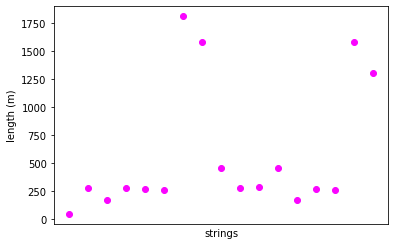

In [98]:
x = [i for i in range(len(straights))]
y = straights

ax = plt.axes()
ax.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
ax.set_ylabel('length (m)')
ax.set_xlabel('strings')

plt.scatter(x, y, color="#FA05FF")
plt.savefig("/Users/nitrotube/Desktop/strings_x.png", bbox_inches='tight', dpi=400)
plt.show()


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_labels = ["<150", "<500", ">500"]
ys = [3273, 1990, 3056]

# add proper binning
ax.bar(x_labels, ys, color=["#3ad21b", "#055AFF", "#FA05FF", "#FFE605"])
plt.xticks(rotation=15)
ax.set_ylabel('number of strings')
ax.set_xlabel('strings length (m)')
plt.savefig("/Users/nitrotube/Desktop/lss.png", bbox_inches='tight', dpi=400)
plt.show()

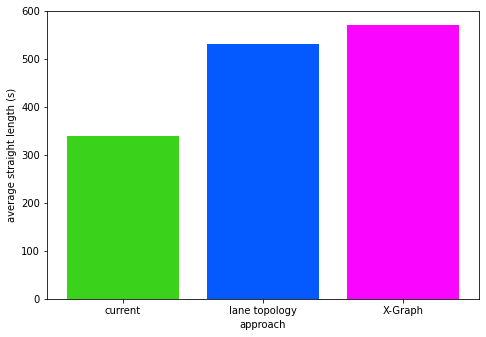

In [101]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
heuristics = ["current", "lane topology", "X-Graph"]
ys = [340, 531, 571.6]
ax.bar(heuristics, ys, color=["#3ad21b", "#055AFF", "#FA05FF"])
ax.set_ylabel('average straight length (s)')
ax.set_xlabel('approach')
plt.savefig("/Users/nitrotube/Desktop/asl.png", bbox_inches='tight', dpi=400)
plt.show()

In [26]:
optimiser = ConnectionsOptimiser(connections=complete_connections,
                                 disjunctions=disjunctions,
                                 matrix=matrix,
                                 local_search_metaheuristic=LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                                 first_solution_strategy=FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
                                 max_optimisation_duration=400,
                                 straight_non_straight_maneuver_penalty=120,
                                 non_straight_straight_maneuver_penalty=0)
optimal_order, optimization_history = optimiser.optimise()
print(f"Optimisation history: {optimization_history}")
optimal_order = optimal_order[1:-1]

Exception: Optimiser error. Route objective 0. 

In [50]:
route_connections = []

for connection in optimal_order:
    route_connections.append(RouteConnection(connection.lanelet_from,
                                             connection.lanelet_to,
                                             0,
                                             2))

# Convert stuff to geojson
rp_json = routing_problem.to_json()
connections_json = [connection.to_json() for connection in route_connections]
geojson = FeatureCollection(features=rp_json + connections_json)

# Show everything on map
color_breaks = [0, 1, 2]
color_stops = create_color_stops(color_breaks, colors=["#3ad21b", "#ff0505", "#d742f5"])
viz = LinestringViz(data=geojson,
                    color_property="type",
                    color_stops=color_stops,
                    line_width_default='2',
                    center=(9.092, 48.731),
                    zoom=18,
                    style=satellite_style)
viz.show()

/Users/nitrotube/thesis/venv/lib/python3.9/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [51]:
route_geojson = []
for connection in optimal_order:
    route_geojson.append(connection.lanelet_from.to_json())
    route_geojson.append(connection.lanelet_to.to_json())

with open("data/route.json", "w") as f:
    json.dump(route_geojson, f)